In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install neo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 665.2/665.2 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 10.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import h5py
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.layers import LSTM

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
sorting_folder = '/content/drive/MyDrive/UCLA_data/Combinato_CSC4_sorted' #Assigning the folder location
sorted_file = os.path.join(sorting_folder, 'sort_pos_simple_0000000_0012718', 'sorting.h5') #Assigning the sorted file within location

#Now we load the sorted file that was gotten after the combinato spike sorting for our post cluster analysis process to begin
with h5py.File(sorted_file, 'r') as f:
  print("Datasets in file after spike sorting:")
  for key in f.keys():
    print(key)

Datasets in file after spike sorting:
artifact_scores
classes
index
matches


In [6]:
#Now we have to inspect each datasets
with h5py.File(sorted_file, 'r') as f:
  artifact_scores = f['artifact_scores'][:] #spikes that are likely artifacts
  classes = f['classes'][:] #These are the cluster labels
  index = f['index'][:] #index of spikes in order of the spike time series
  matches = f['matches'][:] #showing number of spikes that match the template
  print(f"Artifact scores shape: {artifact_scores.shape}")
  print(f"Classes shape: {classes.shape}")
  print(f"Index shape: {index.shape}")
  print(f"Matches shape: {matches.shape}")
  print(f"Artifact scores: {artifact_scores[:10]}")
  print(f"Classes (Cluster labels): {classes[:10]}")
  print(f"Spike Indices: {index[:10]}")
  print(f"Matches: {matches[:10]}")

Artifact scores shape: (10, 2)
Classes shape: (12696,)
Index shape: (12696,)
Matches shape: (12696,)
Artifact scores: [[0 0]
 [1 0]
 [2 0]
 [3 0]
 [4 0]
 [5 0]
 [6 0]
 [7 0]
 [8 1]
 [9 0]]
Classes (Cluster labels): [1 0 0 0 0 0 0 0 0 1]
Spike Indices: [0 1 2 3 4 5 6 7 8 9]
Matches: [1 0 0 0 0 0 0 0 0 0]


**Artifact Scores ((10, 2) shape):**
This dataset has two columns. The first column likely represents the spike index, and the second column indicates whether the spike was marked as an artifact (1 for artifact, 0 for non-artifact).
[8 1] means the 9th spike is classified as an artifact.

**Classes (Cluster Labels):**
The array represents the cluster assignment of each spike.
The value 0 may denote noise, while other numbers (e.g., 1, 2, etc.) likely represent different clusters.

**Index:**
Index likely maps to the spike's location in the original time series, which helps trace back spikes to their temporal positions.

**Matches:**
Appears to indicate if spikes matched a specific sorting template (e.g., 1 for a match, 0 otherwise). It aligns with the artifact scores.

**Unique Classes and Counts:** (Found in the cell below)

Cluster 0 (noise) dominates with 9107 spikes.
Other clusters have varying numbers of spikes, with cluster 1 being the largest among the classified spikes.

Unique classes: [0 1 2 3 4 5 6 7 8 9]
Counts: [9107 1859   40 1408   42  124   17   20   31   48]


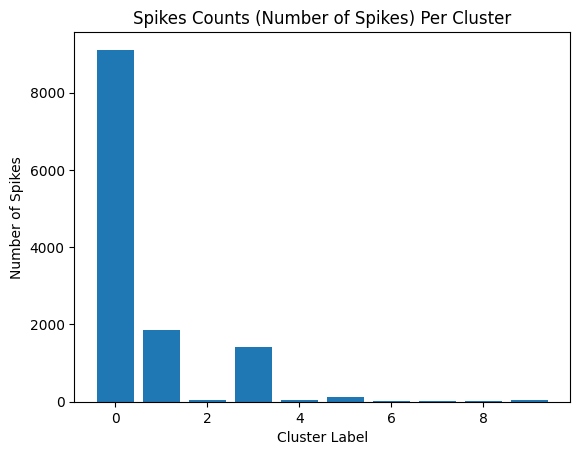

In [7]:
#In order to see the spikes corresponding to each clusters (Number of Spikes or Spike counts per cluster)
unique_classes, counts = np.unique(classes, return_counts=True)
print(f"Unique classes: {unique_classes}")
print(f"Counts: {counts}")
plt.bar(unique_classes, counts)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Spikes")
plt.title("Spikes Counts (Number of Spikes) Per Cluster")
plt.show()

In [8]:
#In order to visualize the Mean Waveform, and the Spike times for each cluster, we connect the preprocessed data to the sorted data.
#Mapping the clusters from sorted data with the spike waveforms and times from the preprocessed data.

# Preprocessing and comparison analysis between automatic and manual spike sorting is found in the UCLA_data folder

prep_folder = '/content/drive/MyDrive/UCLA_data/' #Loading combinato preprocessed data
prep_file = os.path.join(prep_folder, 'combinato_CSC4.h5')

with h5py.File(prep_file, 'r') as f: #Open the file
  print("Datasets in file after Preprocessing:")
  for key in f.keys():
    print(key)
  # Accessing the datasets after iterating through keys
  pos_spikes = np.array(f['pos/spikes'])
  pos_times = np.array(f['pos/times'])
  neg_spikes = np.array(f['neg/spikes'])
  neg_times = np.array(f['neg/times'])
  print(f"neg_spikes shape: {neg_spikes.shape}")
  print(f"neg_times shape: {neg_times.shape}")
  print(f"pos_spikes shape: {pos_spikes.shape}")
  print(f"spikes shape: {pos_spikes.shape}")

#We combine them together so we can have one spike waveform and one spike times
all_spikes = np.concatenate((pos_spikes, neg_spikes), axis=0)
all_times = np.concatenate((pos_times, neg_times), axis=0)
print(f"All spikes waveforms: {all_spikes.shape}")
print(f"All times shape: {all_times.shape}")

Datasets in file after Preprocessing:
neg
pos
thr
neg_spikes shape: (1917, 64)
neg_times shape: (1917,)
pos_spikes shape: (12719, 64)
spikes shape: (12719, 64)
All spikes waveforms: (14636, 64)
All times shape: (14636,)


In [9]:
#Mapping the clusters from spike sorted data to the spike waveforms and times from preprocessed data.
clusters = np.unique(classes) #classes is the cluster label initially gotten after inspecting the sorted dataset
cluster_data = {cls: {'waveforms': [], 'times': []} for cls in clusters} #Creating a dictionary to store spike waveforms and times by clusters

for i, cluster in enumerate(classes):
  spike_idx = index[i]
  cluster_data[cluster]['waveforms'].append(all_spikes[spike_idx])
  cluster_data[cluster]['times'].append(all_times[spike_idx])

for cls in clusters: #Converting the dictionary to a numpy array for easy data workflow
  cluster_data[cls]['waveforms'] = np.array(cluster_data[cls]['waveforms'])
  cluster_data[cls]['times'] = np.array(cluster_data[cls]['times'])

print(f"Cluster data dictionary content: {cluster_data}")

Cluster data dictionary content: {0: {'waveforms': array([[  1.8226696 ,   3.4966142 ,   4.517519  , ...,  -9.072028  ,
        -11.461037  , -13.646786  ],
       [ -3.1398013 ,  -1.6629838 ,  -1.4376118 , ...,   1.6657355 ,
          2.6900442 ,   3.8528807 ],
       [  1.9916631 ,   0.64247483,  -1.7429368 , ...,  -5.380164  ,
         -2.6777444 ,  -1.424303  ],
       ...,
       [  7.122269  ,   3.5584211 ,  -2.2495244 , ...,  -7.006717  ,
         -4.2551994 ,  -5.4880137 ],
       [-16.785295  , -19.166355  , -20.630356  , ...,  -2.5835898 ,
         -4.103048  ,  -5.1658797 ],
       [ -8.2165    ,  -9.260136  , -11.846312  , ...,   1.4272721 ,
          3.4577157 ,   4.048536  ]], dtype=float32), 'times': array([ 125581.562,  125883.533,  125905.605, ..., 2015267.968,
       2015401.392, 2015432.33 ])}, 1: {'waveforms': array([[ -2.2709095 ,   2.1558015 ,   2.9384105 , ...,  -0.3299552 ,
         -1.0596982 ,  -2.599278  ],
       [ -3.2670786 ,  -2.7511508 ,  -2.2808347 , ..

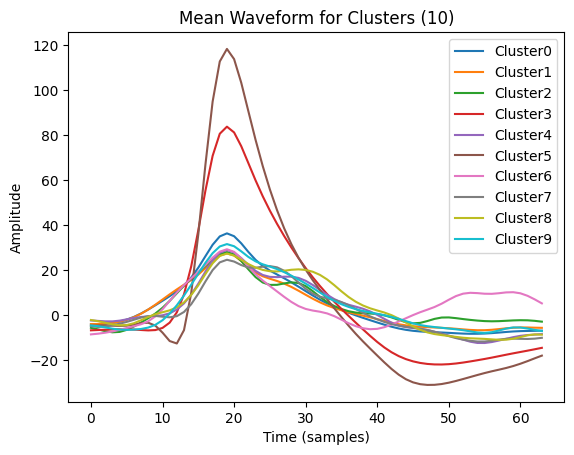

In [10]:
#Plotting the Mean Waveform
for cls in clusters:
  mean_waveform = cluster_data[cls]['waveforms'].mean(axis=0)
  plt.plot(mean_waveform, label = f'Cluster{cls}')
plt.title(f"Mean Waveform for Clusters ({cls + 1})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

**Reason for the choice of "Samples" as unit for Time instead of seconds(s) or milliseconds(ms).**

The spike times which can be found by inspecting the dataset are also represented as indices (index) in the data array.

So, if the dataset has a sampling rate of 32,051 Hz (inspected from the dataset during the UCLA_data manual preprocessing analysis), it means a spike at index 32051 corresponds to 1 second in real time.

**Why I used samples:** It's simpler to process spike times as raw indices ("times" dataset from the data) when working directly with numpy arrays. This avoids the need for conversions during the initial analysis.

The spike times can be converted into real-world time units using the sampling rate and formula:

Time in seconds = Sample Index (spike times) / Sampling Rate (Hz)
Times in milliseconds = (Spike Times / Sampling Rate) * 1000

**Why we may want to convert from samples index to seconds:** Real-world time units are more intuitive and essential for understanding temporal dynamics like firing rates, interspike intervals, and phase relationships.

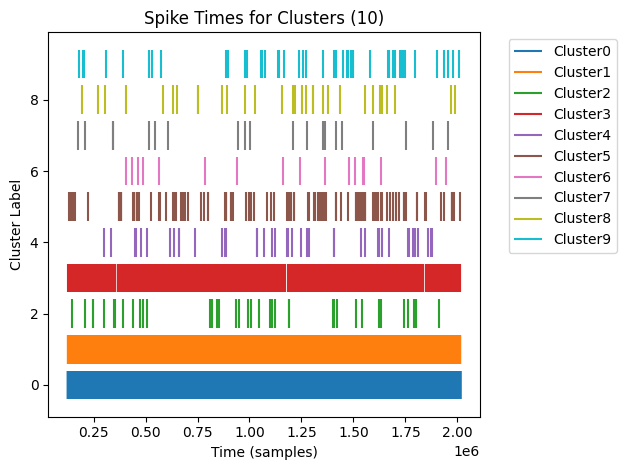

In [11]:
#Visualizing the spike times for each cluster
num_clusters = len(clusters)
colors = cm['tab10'] #For color map so each cluster can have different colors
for idx, cls in enumerate(clusters):
  spike_times = cluster_data[cls]['times']
  plt.vlines(spike_times, cls - 0.4, cls + 0.4, color = colors(idx / num_clusters), label = f'Cluster{cls}')
plt.title(f"Spike Times for Clusters ({cls + 1})")
plt.xlabel("Time (samples)")
plt.ylabel("Cluster Label")
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.tight_layout()
plt.show()

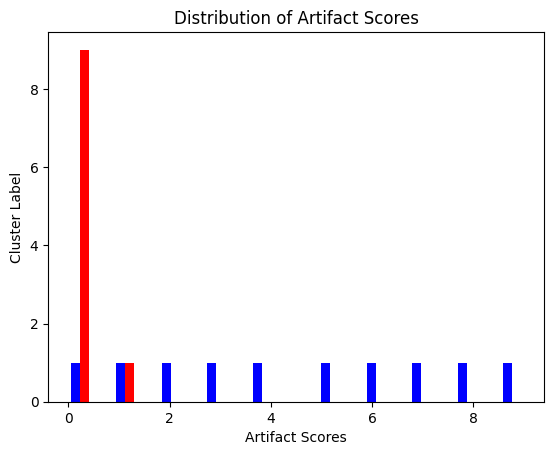

Total Spikes: 12696
Number of Artifacts: 1 (0.01%)


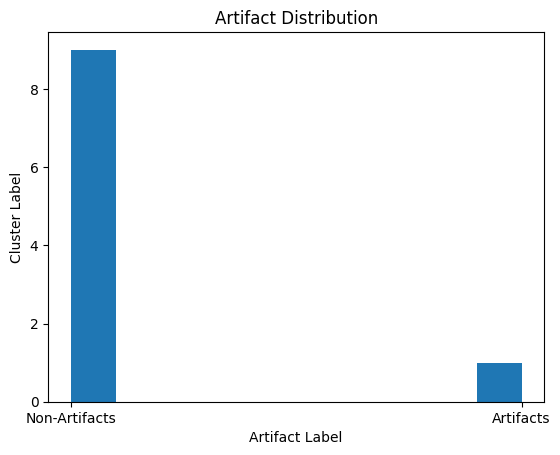

In [12]:
#We visualize how the Artifact Scores are distrubuted per cluster
plt.hist(artifact_scores, bins=20, color=['blue', 'red'])
plt.xlabel("Artifact Scores")
plt.ylabel("Cluster Label")
plt.title("Distribution of Artifact Scores")
plt.show()

# Calculate artifact proportions (Artifact score analysis)
artifact_labels = artifact_scores[:, 1]
total_spikes = len(classes)
num_artifacts = np.sum(artifact_labels)
artifact_percentage = (num_artifacts / total_spikes) * 100

print(f"Total Spikes: {total_spikes}")
print(f"Number of Artifacts: {num_artifacts} ({artifact_percentage:.2f}%)")

# Visualize artifact distribution
plt.hist(artifact_labels, bins=10)
plt.xticks([0, 1], ['Non-Artifacts', 'Artifacts'])
plt.xlabel('Artifact Label')
plt.ylabel('Cluster Label')
plt.title('Artifact Distribution')
plt.show()

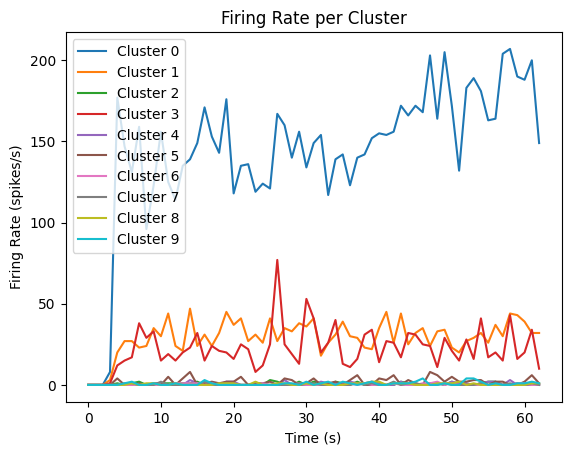

In [13]:
#Visualizing the Firing rates for each cluster of neurons
bin_width = 1  #Firing rate binned over 1-seconds.

#Using 100ms bins gives means Higher Temporal Resolution. We can capture finer temporal dynamics and rapid channges in firing activity compared to 1-second bins.
#However, downside includes Potential Noisiness, due to fewer spikes in each bin. Especially for clusters with low firing rates.

sampling_rate = 32054 #Value was obtained from inspecting the data during manual preprocessing with python pipeline

time_range = (0, max(all_times) / sampling_rate)  # Full recording duration and converted from samples to seconds too

#We add colors to differentiate each spike times by their cluster from the cluster data dictionary
num_clusters = len(clusters)
colors = cm['tab10'] #colormap

# Now we compute firing rates for each cluster
for idx, cls in enumerate(clusters):
    # Getting the spike times for the current cluster
    spike_times = cluster_data[cls]['times'] / sampling_rate  # Converting time from samples to seconds

    #Histogram (spike counts per bin)
    bin_edges = np.arange(time_range[0], time_range[1] + bin_width, bin_width)
    counts, _ = np.histogram(spike_times, bins=bin_edges)

    #Calculating firing rate spikes per seconds
    firing_rate = counts / bin_width  # Normalize by bin width

    # Plot firing rate
    plt.plot(bin_edges[:-1], firing_rate, label=f'Cluster {cls}', color=colors(idx / num_clusters))

# Plot labels
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (spikes/s)')
plt.title('Firing Rate per Cluster')
plt.legend()
plt.show()


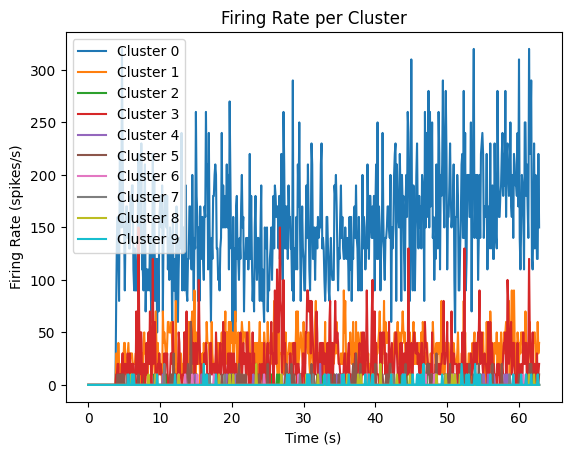

In [14]:
#Visualizing the Firing rates for each cluster of neurons
bin_width = 0.1  #Firing rate binned over 100ms instead of 50ms to minimize noise.

sampling_rate = 32054 #Value was obtained from inspecting the data during manual preprocessing with python pipeline

time_range = (0, max(all_times) / sampling_rate)  # Full recording duration and converted from samples to seconds too

#We add colors to differentiate each spike times by their cluster from the cluster data dictionary
num_clusters = len(clusters)
colors = cm['tab10'] #colormap

# Now we compute firing rates for each cluster
for idx, cls in enumerate(clusters):
    # Getting the spike times for the current cluster
    spike_times = cluster_data[cls]['times'] / sampling_rate  # Converting time from samples to seconds

    #Histogram (spike counts per bin)
    bin_edges = np.arange(time_range[0], time_range[1] + bin_width, bin_width)
    counts, _ = np.histogram(spike_times, bins=bin_edges)

    #Calculating firing rate spikes per seconds
    firing_rate = counts / bin_width  # Normalize by bin width

    # Plot firing rate
    plt.plot(bin_edges[:-1], firing_rate, label=f'Cluster {cls}', color=colors(idx / num_clusters))

# Plot labels
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (spikes/s)')
plt.title('Firing Rate per Cluster')
plt.legend()
plt.show()


Cluster 0: SNR = 7.88
Cluster 1: SNR = 6.03
Cluster 2: SNR = 6.30
Cluster 3: SNR = 18.67
Cluster 4: SNR = 7.30
Cluster 5: SNR = 26.37
Cluster 6: SNR = 6.68
Cluster 7: SNR = 6.42
Cluster 8: SNR = 6.77
Cluster 9: SNR = 6.97


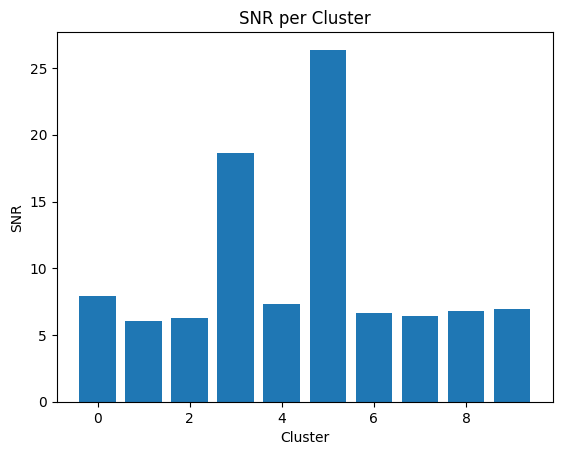

In [15]:
#Calculating the SNR to quantify the noise

#Loading filtered signal from the previously saved filtered signals from manual preprocessing
filtered_signal = np.load('/content/drive/MyDrive/UCLA_data/filtered_signal.npy')

def calculate_snr(waveforms, filtered_signal, spike_indices):
    # We calculate the signal amplitude (peak-to-peak of waveforms)
    signal_amplitude = np.ptp(waveforms.mean(axis=0))

    # We exclude the spike periods to calculate the noise
    spike_window = 30  # Window size around each spike index to exclude
    spike_mask = np.zeros_like(filtered_signal, dtype=bool)
    for idx in spike_indices:
        spike_mask[max(0, idx - spike_window): min(len(filtered_signal), idx + spike_window)] = True

    # Noise is the standard deviation of the signal outside spike periods
    noise_std = np.std(filtered_signal[~spike_mask])

    # Compute SNR
    snr = signal_amplitude / noise_std
    return snr

# Calculate SNR for each cluster
snr_results = {}
for cls in clusters:
    waveforms = cluster_data[cls]['waveforms']
    spike_indices = cluster_data[cls]['times'].astype(int)  # Taking times are indices
    snr = calculate_snr(waveforms, filtered_signal, spike_indices)
    snr_results[cls] = snr
    print(f"Cluster {cls}: SNR = {snr:.2f}")

#Plot for SNR
plt.bar(snr_results.keys(), snr_results.values())
plt.xlabel('Cluster')
plt.ylabel('SNR')
plt.title('SNR per Cluster')
plt.show()

## Interpreting the SNR result

**Cluster 5 (SNR = 26.37):**
This cluster has the highest SNR, indicating very clean signals relative to noise. This could represent neurons with robust and clear spikes.

**Cluster 3 (SNR = 18.67):**
This also shows a high SNR, suggesting good-quality spike waveforms.

**Other Clusters (SNR ~6–8):**
These have moderate SNR values. They aren't as clean as Clusters 3 and 5, but they still contain useful information but might have more noise mixed in.

Lower SNR may need adjustments with the thresholds used in spike sorting or may need additional filtering to be done. The low SNR may also be due to some factors such as: Smaller spike amplitudes; Overlapping noise in spike waveforms; Potentially misclassified spikes.

# ANN/RNN Modeling

Building and training a ANN/RNN Model with our analyzed data.

We will compare between ANN and RNN model to see which one fits best or works best with what we need.

In [22]:
#With sklearn.model and train_test_split

# Parameters
bin_width = 0.05  # 50 ms binned firing rate for all cluster
time_range = (0, max(all_times) / sampling_rate)  # Convert to seconds
bins = np.arange(time_range[0], time_range[1] + bin_width, bin_width)

# Binning firing rates
binned_firing_rates = []
for cls in clusters:
    spike_times = cluster_data[cls]['times'] / sampling_rate  # Convert to seconds
    counts, _ = np.histogram(spike_times, bins=bins)
    firing_rate = counts / bin_width
    binned_firing_rates.append(firing_rate)

# Convert to 2D array (clusters x time bins)
firing_rate_matrix = np.array(binned_firing_rates).T

# Creating labels (e.g. stimulus categories)
# For this example, we'll use dummy labels (replace with real labels if available)
num_bins = firing_rate_matrix.shape[0]
labels = np.random.choice([0, 1], size=num_bins)  # Example: binary labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(firing_rate_matrix, labels, test_size=0.2, random_state=42)

# # If separate datasets are required for ANN and RNN (like different shapes), split for both
# X_train_ann, X_val_ann = X_train, X_val  # ANN uses flattened data
# X_train_rnn, X_val_rnn = X_train, X_val  # RNN uses time-series data
# y_train_ann, y_val_ann = y_train, y_val
# y_train_rnn, y_val_rnn = y_train, y_val

In [23]:
#Building our ANN model using tensorflow with keras & sequential

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4793 - loss: 2.6059 - val_accuracy: 0.5198 - val_loss: 0.7734
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4816 - loss: 1.6539 - val_accuracy: 0.4921 - val_loss: 1.2400
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5173 - loss: 1.1964 - val_accuracy: 0.4683 - val_loss: 0.7437
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5221 - loss: 1.1123 - val_accuracy: 0.4722 - val_loss: 0.8046
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4995 - loss: 1.0757 - val_accuracy: 0.5317 - val_loss: 0.7119
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5165 - loss: 0.9234 - val_accuracy: 0.4881 - val_loss: 0.7324
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4910 - loss: 0.9401 - val_accuracy: 0.5000 - val_loss: 0.7563
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4832 - loss: 0.9488 - val_accuracy: 0.5040 - val_loss: 0.7464
Ep

In [24]:
#Building our RNN model using tensorflow LSTM

# Reshape data for RNN (time steps, features)
X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the RNN model
rnn_model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_rnn, y_test))

# Evaluate the model
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test_rnn, y_test)
print(f"RNN Test Accuracy: {rnn_test_accuracy * 100:.2f}%")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5151 - loss: 0.6999 - val_accuracy: 0.5198 - val_loss: 0.6919
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5115 - loss: 0.6959 - val_accuracy: 0.5635 - val_loss: 0.6886
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5365 - loss: 0.6897 - val_accuracy: 0.5238 - val_loss: 0.6936
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5492 - loss: 0.6814 - val_accuracy: 0.5159 - val_loss: 0.6938
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5846 - loss: 0.6806 - val_accuracy: 0.5159 - val_loss: 0.6939
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5285 - loss: 0.6821 - val_accuracy: 0.4960 - val_loss: 0.6944
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5544 - loss: 0.6775 - val_accuracy: 0.5159 - val_loss: 0.6974
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5651 - loss: 0.6781 - val_accuracy: 0.5159 - val_loss: 0.6990
Ep

A quick analysis from the results:

---

#### **ANN**
- **Accuracy Progress**: The accuracy fluctuates initially but shows a slight improvement over epochs (starting from ~49% and reaching ~55% by Epoch 6).
- **Loss Behavior**: The training loss consistently decreases, indicating the model is learning, but the validation loss increases after Epoch 4, suggesting possible overfitting or poor generalization.
- **Performance**: Val accuracy of ~55.16% after six epochs is slightly better than chance but needs further tuning.


#### **RNN**
- **Accuracy Progress**: Accuracy steadily improves, especially after Epoch 3, reaching ~60.28% by Epoch 5 on training data and ~57.14% on validation data.
- **Loss Behavior**: The loss reduces for both training and validation, indicating the model is generalizing better than the ANN.
- **Performance**: Val accuracy of ~57.14% suggests the RNN is marginally better at capturing temporal dependencies compared to the ANN.

---

### **Suggestions for Improvement**

#### 1. **Data Preprocessing**:
   - **Normalize the Firing Rates**: Ensure all inputs are normalized (e.g., z-scored) to stabilize training.
   - **Label Refinement**: Ensure that the labels align well with the dataset's structure. If using random labels, switch to task-relevant or biologically meaningful labels.
   - **Augment Data**: If the dataset is small, consider techniques like jittering spike times or generating synthetic data to increase size.

#### 2. **Hyperparameter Tuning**:
   - For ANN:
     - Add more layers or neurons in each layer.
     - Experiment with activation functions (e.g., try `tanh` or `LeakyReLU` instead of `relu`).
     - Use a learning rate scheduler or manually reduce the learning rate after a few epochs.
   - For RNN:
     - Add more LSTM/GRU units or increase the number of layers.
     - Use dropout within the LSTM layers (e.g., `recurrent_dropout=0.2`).

#### 3. **Experiment with Binning**:
   - Test smaller or larger bin sizes (e.g., 10ms or 100ms) to better align with neural activity patterns.

#### 4. **Model Enhancements**:
   - Add **Batch Normalization** layers for better convergence.
   - Try more complex models like **Bidirectional LSTMs** or **GRUs**.
   - Explore attention mechanisms to focus on critical time steps in the data.

#### 5. **Regularization**:
   - Increase dropout rates or use L2 regularization (`kernel_regularizer`).

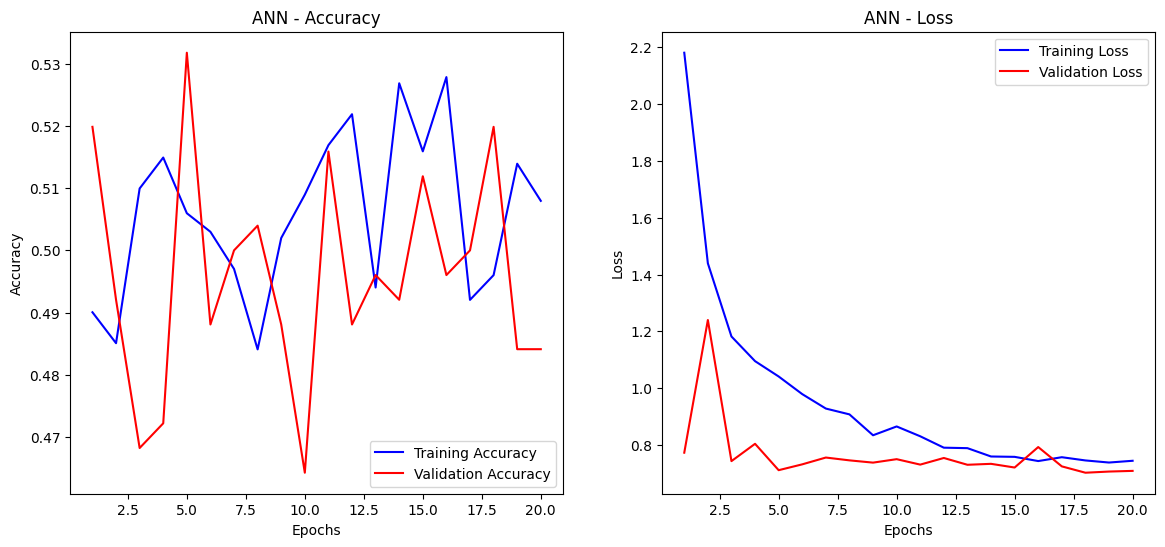

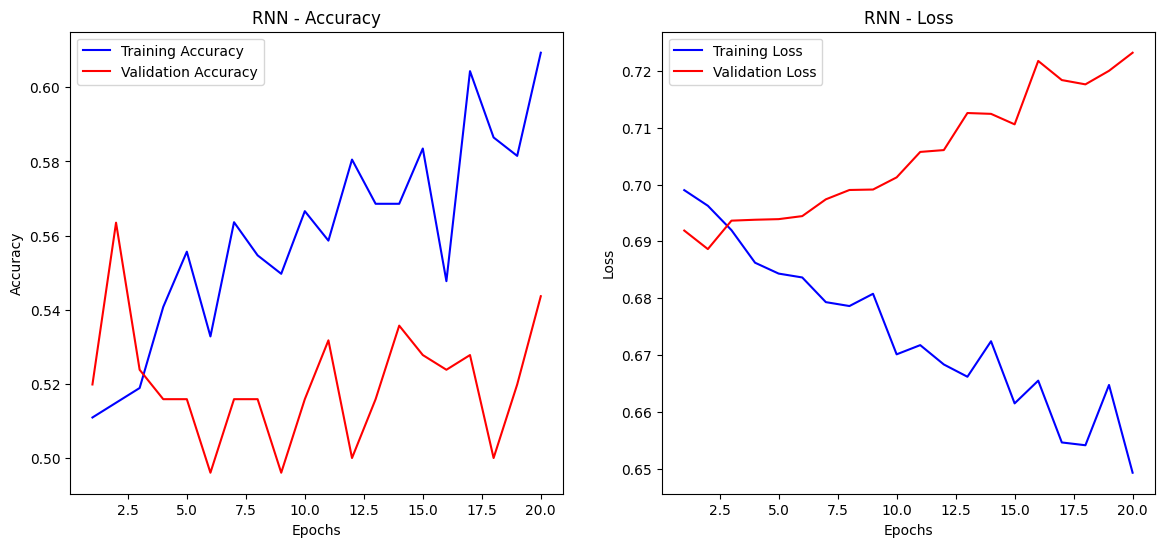

In [25]:
#In order to inspect whether there is overfitting or underfitting (generalization) in the models, we plot the accuracy and losses of the results across the epochs.

# Assuming 'history_ann' and 'history_rnn' are the history objects from the model.fit() calls.


def plot_learning_curves(history, model_name):
    # Extract training and validation accuracy/loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot for ANN
plot_learning_curves(history, "ANN")

# Plot for RNN
plot_learning_curves(rnn_history, "RNN - LSTM")


### **Interpreting the Graph**

- **Training Accuracy/Loss:**
These metrics reflect how well the model is learning the patterns in the training data. A higher training accuracy and a lower training loss generally indicate better learning.

- **Validation Accuracy/Loss:** These are crucial for understanding how well the model generalizes to unseen data (data not used for training). Ideally, you want to see validation accuracy close to or even higher than training accuracy, and validation loss close to or even lower than training loss. This indicates the model is not overfitting to the training data (memorizing it) but is learning generalizable patterns.

<br>

### **How to interpret the curves:**

1. **Accuracy Curves:**

- Training accuracy should generally increase over epochs, showing the model is learning.
- Validation accuracy should also increase, but if it starts to plateau or even decrease while training accuracy keeps increasing, it might be a sign of overfitting.

2. **Loss Curves:**

- Training loss should generally decrease over epochs, indicating the model is improving its predictions.
- Validation loss should also decrease, but if it starts to increase while training loss keeps decreasing, it's another sign of overfitting.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


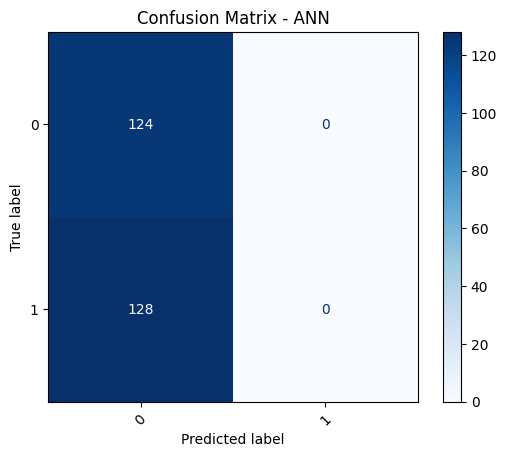

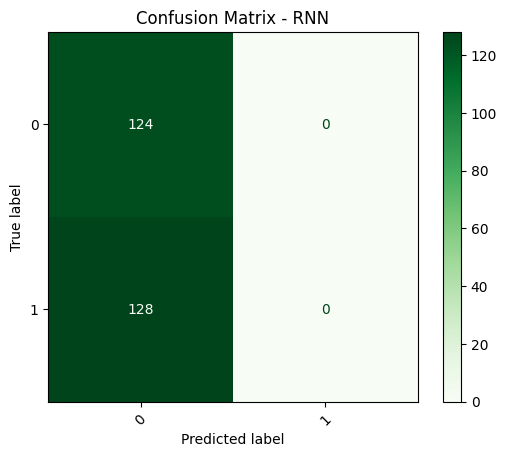

In [29]:
#Plotting confusion matrix to visualize the measurement of our models' preidction error to the actual labels.

# Make predictions for ANN
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)  # Predictions for ANN
y_true = y_test #np.argmax(y_test, axis=1)  # True labels (assuming one-hot encoding)

# Make predictions for RNN
y_pred_rnn = np.argmax(rnn_model.predict(X_test_rnn), axis=1)  # Predictions for RNN

# ANN Confusion Matrix
cm_ann = confusion_matrix(y_true, y_pred_ann)
disp_ann = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=np.unique(y_true))
disp_ann.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - ANN")
plt.show()

# RNN Confusion Matrix
cm_rnn = confusion_matrix(y_true, y_pred_rnn)
disp_rnn = ConfusionMatrixDisplay(confusion_matrix=cm_rnn, display_labels=np.unique(y_true))
disp_rnn.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - RNN - LSTM")
plt.show()


## **Understanding the Confusion Matrix Layout**

1. Rows = True Labels (Ground Truth): The first row represents instances where the true label is 0. The second row represents instances where the true label is 1.

2. Columns = Predicted Labels (Model Predictions): The first column represents instances predicted as 0. The second column represents instances predicted as 1.

### **How to Interpret It**

Each cell in the matrix shows the count of samples that fall into that category:

[Row 0, Col 0]: True Negatives (TN) – Predicted as 0, and the true label is 0.

[Row 0, Col 1]: False Positives (FP) – Predicted as 1, but the true label is 0.

[Row 1, Col 0]: False Negatives (FN) – Predicted as 0, but the true label is 1.

[Row 1, Col 1]: True Positives (TP) – Predicted as 1, and the true label is 1.

### **Observations:**

First Row (True Label = 0):

124 samples were predicted as 0 → True Negatives (TN) = 124.
0 samples were predicted as 1 → False Positives (FP) = 0.
Second Row (True Label = 1):

128 samples were predicted as 0 → False Negatives (FN) = 128.
0 samples were predicted as 1 → True Positives (TP) = 0.

**True Positives (TP):** There are no true positives (predictions of label 1 correctly classified as 1).

**True Negatives (TN):** The model correctly classified 124 instances of label 0 as 0.

**False Positives (FP):** The model did not classify any label 0 as 1 (no false positives).

**False Negatives (FN):** All 128 instances of label 1 were incorrectly classified as 0.


### **Interpretation:**

The ANN model has a severe class imbalance issue or poor generalization ability for label 1. It predicts only label 0 for all samples, which is why the confusion matrix is skewed.
The accuracy metric may be misleading in this case, as the model heavily favors the majority class (label 0).


## **Based on the higher accuracy and suitability of the RNN LSTM layers model, we will proceed with the RNN model optimization and analysis.**